In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

In [2]:
CATEGORIES = ["top_10", "bottom_10", "top_10_aug", "top_10_aut"]
SEAS_START, SEAS_END = "2021-08-01", "2024-08-31"
PERIOD = 12     # monthly data

In [7]:
df = (
    pd.read_csv("data/output/time_series.csv")
    .query(f'date >= "{SEAS_START}"')
    .assign(date=lambda x: pd.to_datetime(x['date'], errors='coerce'))
    .sort_values("date")
    .assign(
        net_jobs_norm=lambda x: (
                x["net_jobs"] - x.groupby("cat")["net_jobs"].transform("mean"))\
                / x.groupby("cat")["net_jobs"].transform("std")
            )
)

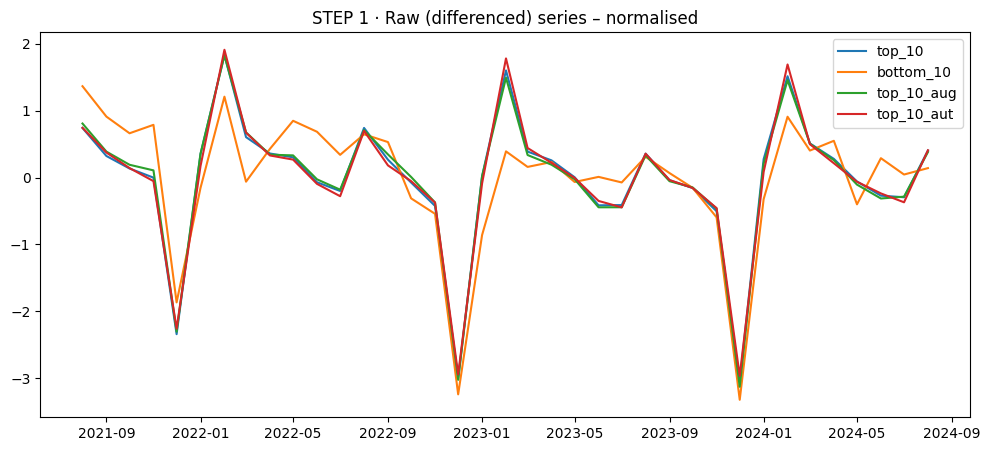

In [8]:
###############################################################
#########  1. BASIC PLOT:  raw normalized job flow series   ###
###############################################################

# Centers and normalizes the data according to the z-score for the category
plt.figure(figsize=(12, 5))
for cat in CATEGORIES:
    sub = df[df["cat"] == cat]
    plt.plot(sub["date"], sub["net_jobs_norm"], label=cat)
plt.title("STEP 1 · Raw (differenced) series – normalised")
plt.legend(); plt.show()

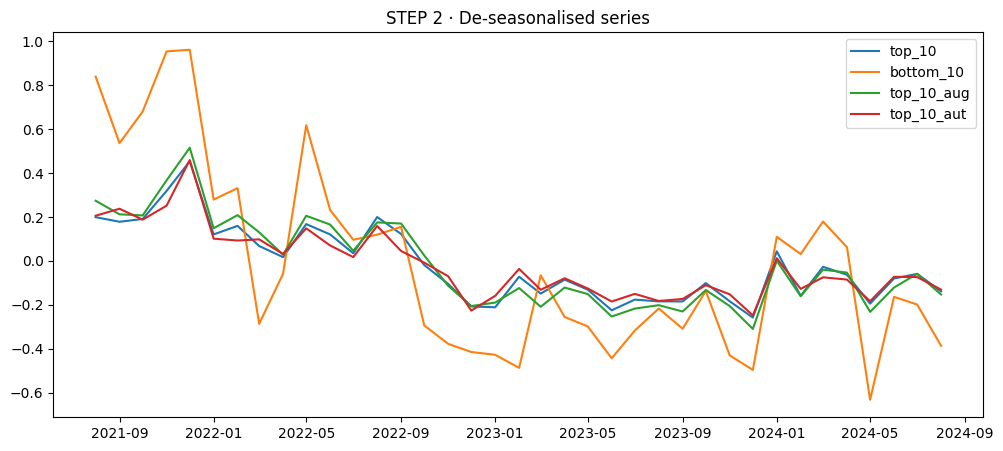

In [9]:
## 2. de-seasonalise via STL (monthly means) ####################3
seasonal_means = {}
for cat in CATEGORIES:
    series = (
                df
                .loc[
                      (df["cat"] == cat) & df["date"].between(SEAS_START, SEAS_END),
                      ["date", "net_jobs_norm"]
                    ]
                .set_index("date")["net_jobs_norm"]
                .asfreq("MS")
                .interpolate()
            )
    
    stl = STL(series, period=PERIOD).fit()
    
    seasonal_means[cat] = stl.seasonal.groupby(stl.seasonal.index.month).mean()

df["seasonal"] = df.apply(lambda r: seasonal_means[r["cat"]].loc[r["date"].month], axis=1)
df["deseas"]   = df["net_jobs_norm"] - df["seasonal"]

plt.figure(figsize=(12, 5))
for cat in CATEGORIES:
    plt.plot(df.loc[df["cat"] == cat, "date"],
             df.loc[df["cat"] == cat, "deseas"], label=cat)
plt.title("STEP 2 · De-seasonalised series")
plt.legend(); plt.show()

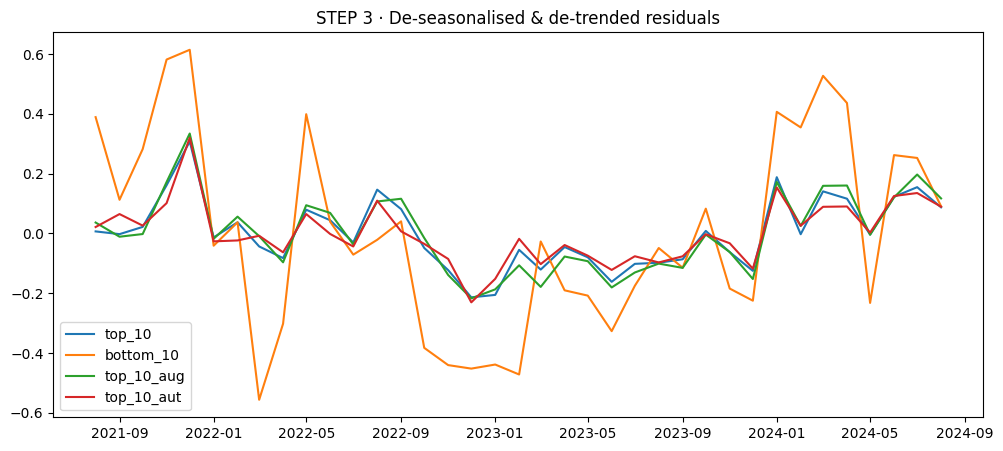

In [13]:
############ 3. remove constant / linear drift ###################################
df["t"] = (df["date"] - df["date"].min()).dt.days / 30   # months

lin_drift = {}

for cat in CATEGORIES:
    mask = df["cat"] == cat
    
    y = df.loc[mask, "deseas"]
    X = sm.add_constant(df.loc[mask, ["t"]])

    ols = sm.OLS(y, X).fit()
    df.loc[mask, "detrend"] = y - ols.fittedvalues
    lin_drift[cat] = {"trend": ols}

plt.figure(figsize=(12, 5))
for cat in CATEGORIES:
    plt.plot(df.loc[df["cat"] == cat, "date"],
             df.loc[df["cat"] == cat, "detrend"], label=cat)
plt.title("STEP 3 · De-seasonalised & de-trended residuals")
plt.legend(); plt.show()

In [15]:
# ───── 4. fit AR(p) on residuals, choose p by AIC 1…6 ───────────────────
for cat in CATEGORIES:
    resid = (df.loc[df["cat"] == cat, ["date", "detrend"]]
               .set_index("date")["detrend"]
               .asfreq("MS"))          # give AutoReg a proper index

    best_aic, best_p, best_model = np.inf, None, None
    for p in range(1, 13):
        mod = AutoReg(resid, lags=p, old_names=False).fit()
        if mod.aic < best_aic:
            best_aic, best_p, best_model = mod.aic, p, mod

    p_adf = adfuller(resid.dropna())[1]
    print(f"{cat:<12} | ADF p={p_adf:.3f} | AR({best_p}) AIC={best_aic:.2f}")

    lin_drift[cat]["ar"] = best_model

top_10       | ADF p=0.518 | AR(1) AIC=-55.86
bottom_10    | ADF p=0.013 | AR(1) AIC=13.22
top_10_aug   | ADF p=0.021 | AR(1) AIC=-50.69
top_10_aut   | ADF p=0.774 | AR(5) AIC=-63.79


In [ ]:
# ───── 5. ARIMA(1,0,1) on residuals ───────────────────────────
for cat in CATEGORIES:
    resid = (df.loc[df['cats'] == cat, ['date', 'detrend']]
               .set_index('date')['detrend']
               .asfreq('MS'))
    arima = ARIMA(resid, order=(1,0,1)).fit()
    print(f'{cat:<12} | ARIMA(1,0,1) AIC={arima.aic:.2f}')
    lin_drift[cat]['arima'] = arima
